In [3]:
import pandas as pd 
from dotenv import load_dotenv
import os 

load_dotenv()

True

In [7]:
movies_df = pd.read_csv(r"C:\Users\bhavi\OneDrive\Desktop\langhcain_learning\RAG\IMDB top 1000.csv")
movies_df[["Title","Metascore","Description","Cast"]].head(2)

,Title,Metascore,Description,Cast
0,1. The Shawshank Redemption (1994),80.0,Two imprisoned men bond over a number of years...,"Director: Frank Darabont | Stars: Tim Robbins,..."
1,2. The Godfather (1972),100.0,The aging patriarch of an organized crime dyna...,Director: Francis Ford Coppola | Stars: Marlon...


In [15]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_chroma import Chroma
from langchain_core.documents import Document

In [17]:
embeddings_model = HuggingFaceEmbeddings(model_name = "all-MiniLM-L6-v2")


In [21]:
documents = []
ids = []

print("Preparing documents...")
for index, row in movies_df.iterrows():
    if index % 100 == 0:
        print(f"--Processing movie {index + 1} of {len(movies_df)}--")
    page_content = str(row["Description"])

    meta_data = {}
    for column in movies_df.columns:
        if column != "Description":
            val = row[column]
            if pd.isna(val):
                meta_data[column] = ""
            else:
                meta_data[column] = val

    documents.append(Document(page_content=page_content, metadata=meta_data))
    ids.append(str(index))

vector_store = Chroma(
    collection_name="movies_collection",
    embedding_function=embeddings_model
)

vector_store.add_documents(documents=documents, ids=ids)

Preparing documents...
--Processing movie 1 of 1000--
--Processing movie 101 of 1000--
--Processing movie 201 of 1000--
--Processing movie 301 of 1000--
--Processing movie 401 of 1000--
--Processing movie 501 of 1000--
--Processing movie 601 of 1000--
--Processing movie 701 of 1000--
--Processing movie 801 of 1000--
--Processing movie 901 of 1000--


['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138'

In [28]:
def find_movies(query, metadata_filter=None, k=3):
    search_filter = metadata_filter if metadata_filter else None
    
    results = vector_store.similarity_search(
        query=query, 
        filter=search_filter, 
        k=k
    )
    
    for doc in results:
        title = doc.metadata.get("Title", "Unknown")
        description = doc.page_content 
        
        print(f"* Title: {title}")
        print(f"  Description: {description}\n")


query = "I like scifi, which movies should I watch?"
metadata_filter = {"Metascore": {"$gte": 90}}

find_movies(query=query,metadata_filter=metadata_filter, k=2)

* Title: 284. Solaris (1972)
  Description: A psychologist is sent to a station orbiting a distant planet in order to discover what has caused the crew to go insane.

* Title: 66. WALL·E (2008)
  Description: In the distant future, a small waste-collecting robot inadvertently embarks on a space journey that will ultimately decide the fate of mankind.



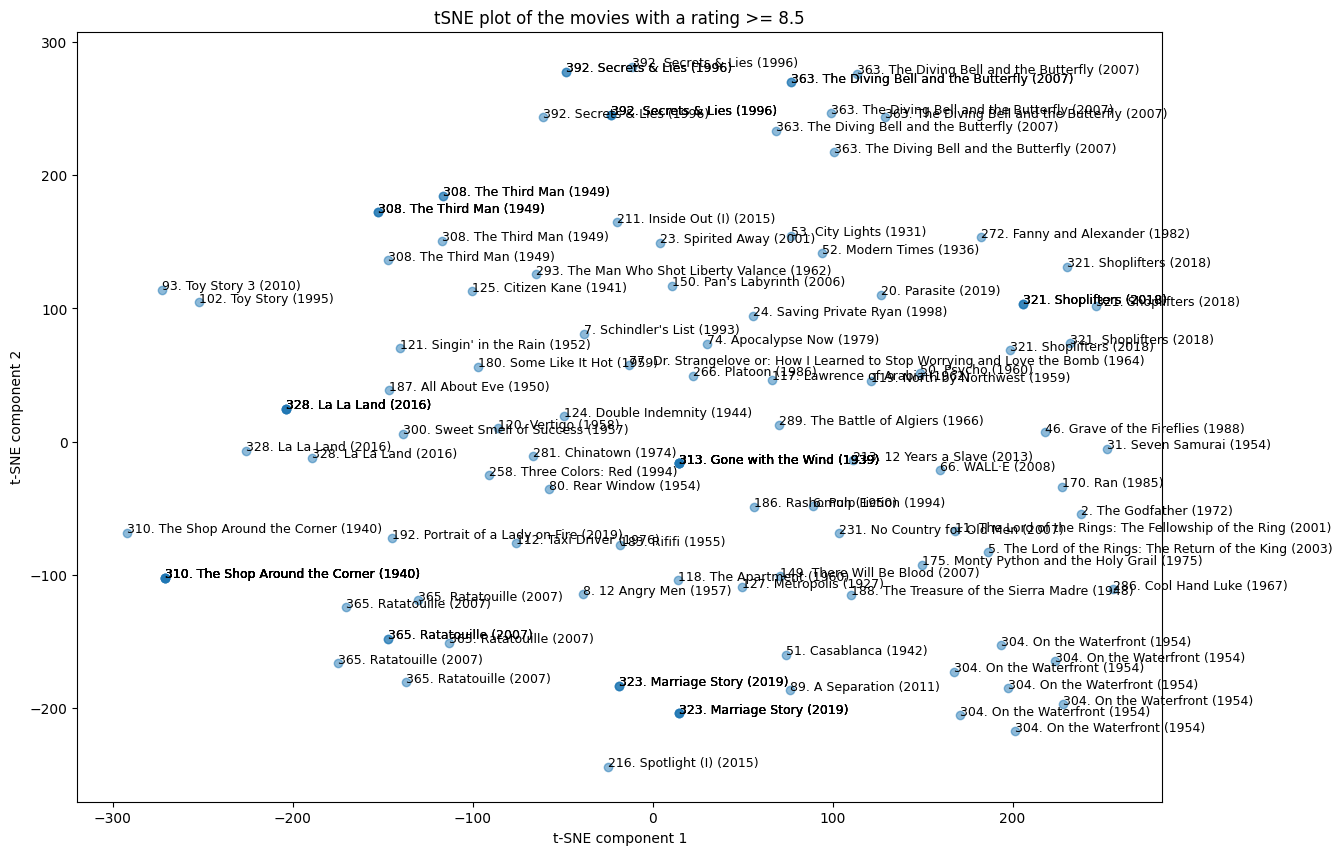

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

collection_subset = vector_store._collection.get(
    include=["embeddings", "metadatas"], where={"Metascore": {"$gt": 90}}
)
embeddings = collection_subset["embeddings"]
metadatas = collection_subset["metadatas"]
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)
plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
for i, metadata in enumerate(metadatas):
    plt.text(
        embeddings_2d[i, 0], embeddings_2d[i, 1], metadata["Title"], fontsize=9
    )
plt.title("tSNE plot of the movies with a rating >= 8.5")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()